In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)




Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/local_remote_synthetic_dialogs_copia/synthetic_dialogs


/content/drive/MyDrive/local_remote_synthetic_dialogs_copia/synthetic_dialogs


In [3]:
!pip install python-dotenv

In [4]:
pip install plotly


=== Summary statistics ===
             auto_mean  human_mean  auto_std  human_std
Fluency            5.0        5.00  0.000000   0.000000
Coherence          5.0        4.90  0.000000   0.307794
Realism            4.0        5.00  0.000000   0.000000
Fidelity           4.3        3.35  0.470162   1.225819
Engagement         4.2        3.95  0.410391   0.394034
Originality        3.0        3.40  0.000000   0.598243

=== Auto vs. Human Correlation (valid columns only) ===
                   Coherence (human)  Fidelity (human)  Engagement (human)  \
Fidelity (auto)             0.218218          0.356153            0.369324   
Engagement (auto)           0.166667          0.376638            0.390567   

                   Originality (human)  
Fidelity (auto)               0.112272  
Engagement (auto)             0.300123  


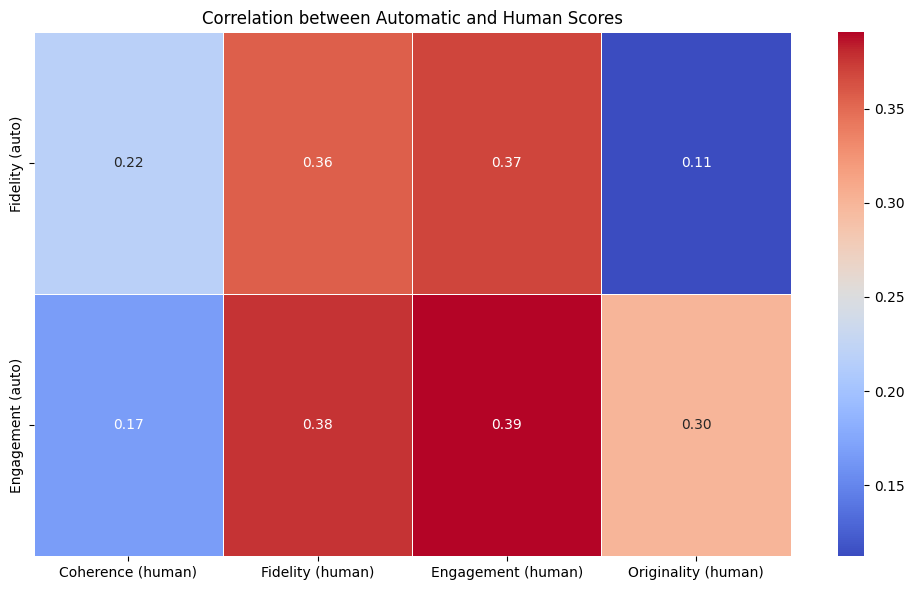

In [5]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

# Set Plotly rendering mode for Google Colab
pio.renderers.default = 'colab'

# === Load Excel file ===
file_path = "/content/drive/MyDrive/local_remote_synthetic_dialogs_copia/synthetic_dialogs/data_llama3_70b_noimperf/evaluation_human_template_noimperf_llama3_70b.xlsx"
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces in column names

# === Define evaluation criteria ===
criteria = ["Fluency", "Coherence", "Realism", "Fidelity", "Engagement", "Originality"]
auto_cols = [f"{c} (auto)" for c in criteria]
human_cols = [f"{c} (human)" for c in criteria]

# === Convert all scoring columns to numeric (in case of text or errors) ===
for col in auto_cols + human_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# === Keep only rows with valid human scores ===
df_clean = df.dropna(subset=human_cols)

# === Summary statistics: means and standard deviations ===
summary = pd.DataFrame(index=criteria)
summary["auto_mean"] = [df_clean[f"{c} (auto)"].mean() for c in criteria]
summary["human_mean"] = [df_clean[f"{c} (human)"].mean() for c in criteria]
summary["auto_std"] = [df_clean[f"{c} (auto)"].std() for c in criteria]
summary["human_std"] = [df_clean[f"{c} (human)"].std() for c in criteria]

print("=== Summary statistics ===")
print(summary)

# === Identify only columns with non-zero variance ===
valid_human_cols = [col for col in human_cols if df_clean[col].std() > 0]
valid_auto_cols = [col for col in auto_cols if df_clean[col].std() > 0]

# === Compute correlation matrix only for valid columns ===
corr_matrix = df_clean[valid_auto_cols + valid_human_cols].corr()
corr = corr_matrix.loc[valid_auto_cols, valid_human_cols]

print("\n=== Auto vs. Human Correlation (valid columns only) ===")
print(corr)

# === Interactive boxplot for score distributions ===
melted = df_clean.melt(value_vars=auto_cols + human_cols, var_name="Metric", value_name="Score")
fig_box = px.box(melted, x="Metric", y="Score", title="Score Distribution: Auto vs. Human")
fig_box.update_layout(xaxis_tickangle=45, width=1000, height=500)
display(fig_box)

# === Scatterplots for each valid metric with reference line y = x ===
for c in criteria:
    auto_col = f"{c} (auto)"
    human_col = f"{c} (human)"

    # Plot only if both columns have variance
    if (
        auto_col in df_clean.columns and human_col in df_clean.columns and
        df_clean[auto_col].std() > 0 and df_clean[human_col].std() > 0
    ):
        fig = px.scatter(
            df_clean, x=auto_col, y=human_col,
            title=f"{c}: Auto vs Human",
            labels={auto_col: "Auto Score", human_col: "Human Score"},
            range_x=[0, 5], range_y=[0, 5]
        )

        # Add diagonal reference line (ideal match)
        fig.add_trace(go.Scatter(
            x=[0, 5], y=[0, 5],
            mode='lines',
            line=dict(dash='dash', color='gray'),
            name='Ideal Match (y=x)'
        ))

        fig.update_layout(width=800, height=800)
        display(fig)

# === Correlation heatmap (NaNs are masked) ===
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, mask=corr.isnull())
plt.title("Correlation between Automatic and Human Scores")
plt.tight_layout()
plt.show()


In [6]:
from sklearn.metrics import mean_absolute_error

# === MAE and Bias per metric ===
mae = []
bias = []

for c in criteria:
    auto_col = f"{c} (auto)"
    human_col = f"{c} (human)"

    if auto_col in df_clean.columns and human_col in df_clean.columns:
        # Remove rows with NaNs
        df_pair = df_clean[[auto_col, human_col]].dropna()

        if df_pair[auto_col].std() > 0 or df_pair[human_col].std() > 0:
            mae_val = mean_absolute_error(df_pair[human_col], df_pair[auto_col])
            bias_val = df_pair[auto_col].mean() - df_pair[human_col].mean()
            mae.append(mae_val)
            bias.append(bias_val)
        else:
            mae.append(None)
            bias.append(None)
    else:
        mae.append(None)
        bias.append(None)

extra_stats = pd.DataFrame({
    "MAE": mae,
    "Bias (Auto - Human)": bias
}, index=criteria)

print("\n=== Extra Evaluation Metrics ===")
print(extra_stats)




=== Extra Evaluation Metrics ===
                MAE  Bias (Auto - Human)
Fluency         NaN                  NaN
Coherence    0.1000               0.1000
Realism         NaN                  NaN
Fidelity     1.1500               0.9500
Engagement   0.2500               0.2500
Originality  0.3125              -0.3125


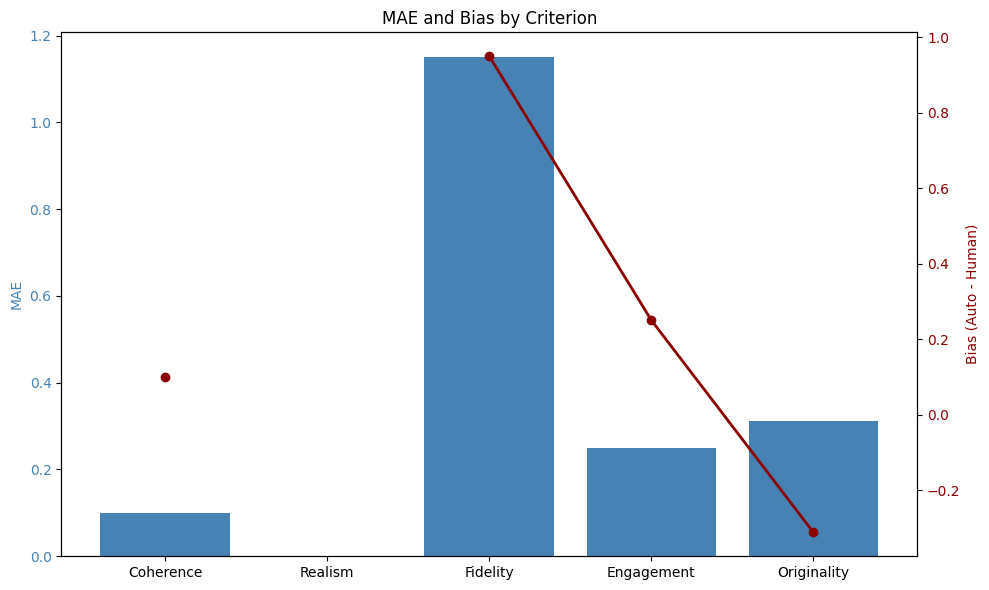

In [9]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

mae = []
bias = []

for c in criteria:
    auto_col = f"{c} (auto)"
    human_col = f"{c} (human)"

    if auto_col in df_clean.columns and human_col in df_clean.columns:
        # Eliminar filas con NaNs en cualquiera de las dos columnas
        df_pair = df_clean[[auto_col, human_col]].dropna()

        if df_pair[auto_col].std() > 0 or df_pair[human_col].std() > 0:
            mae_val = mean_absolute_error(df_pair[human_col], df_pair[auto_col])
            bias_val = df_pair[auto_col].mean() - df_pair[human_col].mean()
            mae.append(mae_val)
            bias.append(bias_val)
        else:
            mae.append(None)
            bias.append(None)
    else:
        mae.append(None)
        bias.append(None)

extra_stats = pd.DataFrame({
    "MAE": mae,
    "Bias (Auto - Human)": bias
}, index=criteria)

# Plot it
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(extra_stats.index, extra_stats["MAE"], color="steelblue", label="MAE")
ax1.set_ylabel("MAE", color="steelblue")
ax1.tick_params(axis='y', labelcolor="steelblue")

ax2 = ax1.twinx()
ax2.plot(extra_stats.index, extra_stats["Bias (Auto - Human)"], color="darkred", marker="o", linewidth=2, label="Bias")
ax2.set_ylabel("Bias (Auto - Human)", color="darkred")
ax2.tick_params(axis='y', labelcolor="darkred")

plt.title("MAE and Bias by Criterion")
plt.tight_layout()
plt.show()
